In [2]:
from IPython.display import clear_output
!pip install tensorflow==2.7.0
clear_output()

In [26]:
import numpy as np 
import sympy as sp
import pandas as pd
import tensorflow as tf
from h5py import File as HDF5File
from PIL import Image
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import imageio
from IPython import display

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize
from numpy import asarray
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

In [3]:
import os
os.chdir(r'/kaggle/working')

In [4]:
jet_mass_datafile = '../input/qgans-jet-mass-dataset/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_mass_datafile, 'r')

In [5]:
print(jet_mass_data.keys())

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>


(872666, 25, 25)


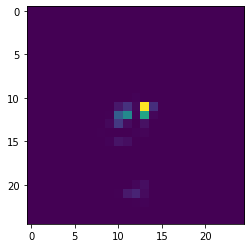

In [6]:
X_jet = jet_mass_data['image']
print(X_jet.shape)
plt.imshow(X_jet[5,:,:])

In [7]:
X_jet = X_jet[:100000,:,:]
print(X_jet.shape)

(100000, 25, 25)


Maximum pixel value for Jet mass images: 312
(100000, 8, 8)


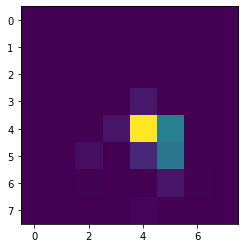

In [8]:
max_val_pix = np.argmax(np.mean(X_jet[:, :, :], axis=0))
print("Maximum pixel value for Jet mass images:",max_val_pix)
center = [int(max_val_pix/25), max_val_pix%25]

img_size = 8
X_jet = X_jet[:, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]

print(X_jet.shape)
plt.imshow(X_jet[0,:,:])

In [9]:
def create_discriminator():
    inputs = tf.keras.Input(shape=(8,8,1))
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(70)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    x = tf.keras.layers.Dense(30)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    x = tf.keras.layers.Dense(10)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    out = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    return tf.keras.Model(inputs=[inputs],outputs=[out])

In [10]:
def create_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(24,input_dim=100))
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Dense(48))
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Reshape((8,8,1)))
    return model

In [11]:
discriminator_model = create_discriminator()
generator_model = create_generator()
discriminator_model.summary()
generator_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 8, 1)]         0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 70)                4550      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 70)                0         
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                2130      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 30)                0     

In [12]:
def generate_and_save_images(model, epoch, batch_size):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  z_batch_shape = (batch_size,) + model.input_shape[1:]
  z = tf.random.normal(z_batch_shape) 
  predictions = model(z, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(4):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [13]:
class QGAN():
  def __init__(self,discriminator,generator,disc_optimizer,gen_optimizer):
    self.generator_model = generator
    self.discriminator_model = discriminator
    self.d_opt = disc_optimizer
    self.g_opt = gen_optimizer
    # self.g_lr = gen_learning_rate
    # self.d_lr = disc_learning_rate
    self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    self.gen_loss_ = []
    self.disc_loss_ = []
    self.epochs_ = []
    # self.d_opt = self.d_opt(self.d_lr)
    # self.g_opt = self.g_opt(self.g_lr)

  def prepare_dataset(self,data,batch_size,seed=None,drop_remainder=True,buffer_size=100):
    buffer_size =len(data[0])
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.shuffle(buffer_size=buffer_size,seed=seed,reshuffle_each_iteration=True)
    ds = ds.batch(batch_size,drop_remainder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

  def train_preprocess(self,random_state):
    tf.random.set_seed(random_state)
    np.random.seed(random_state)
  
  @tf.function
  def generator_loss(self,fake_output):
    return self.loss(tf.ones_like(fake_output),fake_output)

  @tf.function
  def discriminator_loss(self,real_output,fake_output):
    real_loss = self.loss(tf.ones_like(real_output),real_output)
    fake_loss = self.loss(tf.zeros_like(fake_output),fake_output)
    return real_loss + fake_loss
  
  @tf.function
  def train_step_1v1(self,x_real,batch_size):
    """Training step for one epoch with 1 generator step and 1 discriminator step
        """
    fake_data_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(shape=fake_data_shape)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      x_fake_ = self.generator_model(z, training=True)
      # x_fake = tf.reshape(x_fake_, tf.shape(x_real))
      real_output = self.discriminator_model(x_real, training=True)
      fake_output = self.discriminator_model(x_fake_, training=True)
      gen_loss = self.generator_loss(fake_output)
      disc_loss = self.discriminator_loss(real_output, fake_output)
    grad_gen = gen_tape.gradient(gen_loss, self.generator_model.trainable_variables)
    grad_disc = disc_tape.gradient(disc_loss, self.discriminator_model.trainable_variables)
    self.g_opt.apply_gradients(zip(grad_gen, self.generator_model.trainable_variables))
    self.d_opt.apply_gradients(zip(grad_disc, self.discriminator_model.trainable_variables))  
    return gen_loss, disc_loss

  @tf.function
  def train_step_nv1(self,x_real,n_disc,batch_size):
    for i in range(n_disc):
      x_real_batch = tf.gather(x_real,i)
      d_loss = self.discriminator_step(x_real_batch,batch_size)
    g_loss = self.generator_step(batch_size)
    return g_loss, d_loss

  @tf.function
  def train_step_1vn(self,x_real,n_gen,batch_size):
    for i in range(n_gen):
      g_loss = self.generator_step(batch_size)
    d_loss = self.discriminator_step(x_real,batch_size)
    return g_loss, d_loss 

  @tf.function
  def discriminator_step(self,x_real,batch_size):
    fake_data_shape = (batch_size,) + self.generator_model.input_shape[1:]
    # x_real = tf.reshape(x_real,fake_data_shape)
    z = tf.random.normal(shape=fake_data_shape)
    with tf.GradientTape() as gradient_tape:
      real_output = self.discriminator_model(x_real,training = True)
      fake_input = self.generator_model(z, training = True) 
      # fake_input = tf.reshape(fake_input, tf.shape(x_real))
      fake_output = self.discriminator_model(fake_input,training = True)
      cost = self.discriminator_loss(real_output,fake_output)
    grad = gradient_tape.gradient(cost,self.discriminator_model.trainable_variables)
    self.d_opt.apply_gradients(zip(grad,self.discriminator_model.trainable_variables))
    return cost

  @tf.function
  def generator_step(self,batch_size):
    fake_data_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(shape=fake_data_shape)
    with tf.GradientTape() as gradient_tape:
      fake_input = self.generator_model(z,training=True)
      fake_output = self.discriminator_model(fake_input,training= True) #
      loss = self.generator_loss(fake_output)
    grad = gradient_tape.gradient(loss,self.generator_model.trainable_variables)
    self.g_opt.apply_gradients(zip(grad,self.generator_model.trainable_variables))
    return loss
  
  def train_qgans(self,x,epochs,batch_size,seed=1024,n_disc=1,n_gen=1):
    input_shape = x.shape[1:]
    self.train_preprocess(seed)
    data = self.prepare_dataset(data=x,batch_size=batch_size*n_disc,seed=seed)
    g_metric = tf.keras.metrics.Mean()
    d_metric = tf.keras.metrics.Mean()
    for epoch in range(epochs):
      for step,training_batch_data_ in enumerate(data):
        # training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
        if( n_disc == 1 and n_gen == 1):
          input_batch_shape = (batch_size,) + input_shape
          training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
          gen_loss,disc_loss = self.train_step_1v1(x_real=training_batch_data, batch_size=batch_size)
          display.clear_output(wait=True)
          generate_and_save_images(self.generator_model,epoch + 1,batch_size)
        if n_disc > 1 and n_gen == 1:
          input_batch_shape = (n_disc, batch_size) + input_shape
          training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
          gen_loss,disc_loss = self.train_step_nv1(x_real=training_batch_data, batch_size=batch_size,n_disc=n_disc)
          display.clear_output(wait=True)
          generate_and_save_images(self.generator_model,epoch + 1,batch_size)
        if n_gen > 1 and n_disc == 1:
          input_batch_shape = (batch_size,) + input_shape
          training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
          gen_loss,disc_loss = self.train_step_1vn(x_real=training_batch_data, batch_size=batch_size,n_gen=n_gen)
          display.clear_output(wait=True)
          generate_and_save_images(self.generator_model,epoch + 1,batch_size)
        g_metric(gen_loss)
        d_metric(disc_loss)
     
      self.gen_loss_.append(g_metric.result().numpy())
      self.disc_loss_.append(d_metric.result().numpy())
      self.epochs_.append(epoch)
      print("Epoch:{} ;   generator_loss:{} ;   discriminator_loss:{}".format(epoch,g_metric.result().numpy(),d_metric.result().numpy()))
  
      g_metric.reset_state()
      d_metric.reset_state()
    display.clear_output(wait=True)
    return self.gen_loss_,self.disc_loss_,self.epochs_

  def generate_samples(self,batch_size, shape=None):
    """Generates sample using random inputs
        
            Arguments:
                batch_size: int
                    Number of samples to generate.
                shape: (Optional) tuple of int
                    Reshape the output to the given shape.
        """
    z_batch_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(z_batch_shape)
    print(z.shape[0])
    samples = self.generator_model(z,training = False)
    # samples = generator_model
    # if shape is not None:
    #   shape = (batch_size,) + shape
    #   samples = tf.reshape(samples, shape)
    return samples

  def predict(self, x):
    return self.discriminator_model(x, training=False)

In [15]:
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model = QGAN(generator=generator_model,discriminator=discriminator_model,disc_optimizer=d_optimizer,gen_optimizer=g_optimizer)

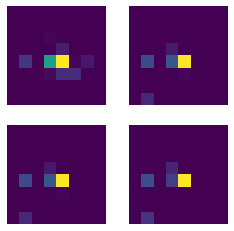

Epoch:299 ;   generator_loss:0.6568252444267273 ;   discriminator_loss:1.4007551670074463


In [16]:
X_jet = np.reshape(X_jet, (X_jet.shape[0], 8, 8, 1))
gen_loss_,disc_loss_,epochs_ = model.train_qgans(X_jet,epochs=300,batch_size=20000,seed=2021,n_gen=5)

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_loss(gen_loss,disc_loss,epochs):
  fig = plt.figure(figsize=(16,9))
  gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
  epoch = epochs[-1]
  # plot loss curve
  ax_loss = plt.subplot(gs[:,:4])
  ax_loss.set_xlim(0, 1.1*epoch)
  ax_loss.plot(epochs, gen_loss, label="Generator")
  ax_loss.plot(epochs, disc_loss, label="Discriminator")
  ax_loss.set_xlabel('Epoch', fontsize=20)
  ax_loss.set_ylabel('Loss', fontsize=20)
  ax_loss.grid(True)
  ax_loss.legend(fontsize=15)

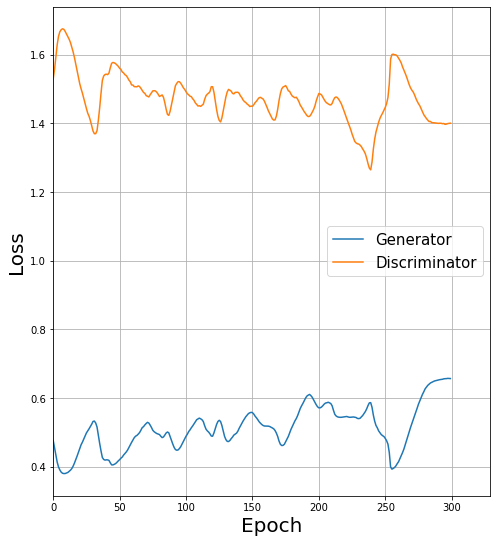

In [18]:
plot_loss(gen_loss_,disc_loss_,epochs_)

8


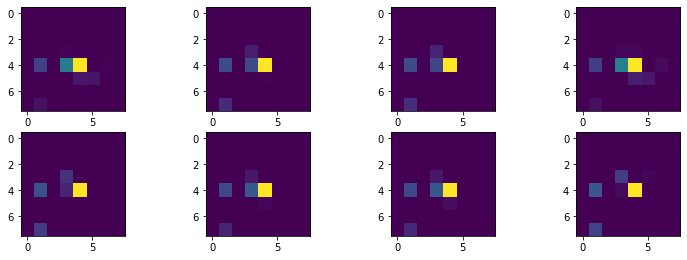

In [19]:
n_images = 8
samples = np.reshape(np.array(model.generate_samples(batch_size=n_images,shape=(5,))),(n_images,8,8))
fig = plt.figure(figsize=(26,18))
gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
for i in range(samples.shape[0]):
  ax = plt.subplot(gs[i//4, 4 + i%4])
  plt.imshow(samples[i])

In [20]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

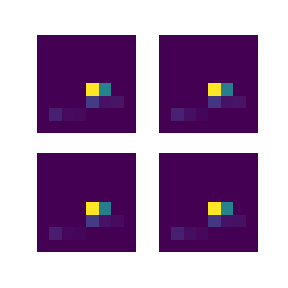

In [21]:
display_image(100)

In [22]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
#   image = imageio.imread(filename)
#   writer.append_data(image)
print(type(anim_file))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  import sys


<class 'str'>


In [23]:
from IPython.display import HTML

HTML('<img src="./dcgan.gif" />')

In [24]:
def FID(model,images_1,images_2):
  images_1 = preprocess_input(images_1)
  images_2 = preprocess_input(images_2)
  
  act1 = model.predict(images_1)
  act2 = model.predict(images_2)
  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
  ssdiff = np.sum((mu1-mu2)**2)
  covmean = sqrtm(sigma1.dot(sigma2))
  if iscomplexobj(covmean):
    covmean =covmean.real
  
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0*covmean)
  return fid

In [25]:
def scale_images(images,size):
  images_list = []
  for image in images:
    new_image = resize(image,size,0)
    images_list.append(new_image)
  return asarray(images_list)

In [27]:
inc_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

87924736/87910968 [==============================] - 1s 0us/step


In [31]:
new_samples = np.reshape(np.array(model.generate_samples(batch_size=1000,shape=(5,))),(1000,8,8))

1000


In [35]:
new_images_e = scale_images(X_jet[:1000],(299,299,3))
new_images_inv = scale_images(new_samples[:1000],(299,299,3))
# new_images_z = scale_images(z[:1000],(299,299,3))
FID(inc_model,new_images_e,new_images_inv)

2022-09-13 20:45:56.043606: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
2022-09-13 20:45:57.226282: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1072812000 exceeds 10% of free system memory.
2022-09-13 20:45:58.188967: E tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded runtime CuDNN library: 8.0.5 but source was compiled with: 8.1.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2022-09-13 20:45:58.190322: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : UNKNOWN: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node inception_v3/conv2d/Conv2D
 (defined at /opt/conda/lib/python3.7/site-packages/keras/layers/convolutional.py:238)
]] [Op:__inference_predict_function_126678]

Errors may have originated from an input operation.
Input Source operations connected to node inception_v3/conv2d/Conv2D:
In[0] IteratorGetNext (defined at /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1610)	
In[1] inception_v3/conv2d/Conv2D/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
>>>     "__main__", mod_spec)
>>> 
>>>   File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 976, in launch_instance
>>>     app.start()
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
>>>     handle._run()
>>> 
>>>   File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
>>>     await result
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
>>>     cell_id=cell_id,
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
>>>     raw_cell, store_history, silent, shell_futures, cell_id
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3029, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
>>>     interactivity=interactivity, compiler=compiler, result=result)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3472, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_17/47201001.py", line 4, in <module>
>>>     FID(inc_model,new_images_e,new_images_inv)
>>> 
>>>   File "/tmp/ipykernel_17/132179129.py", line 5, in FID
>>>     act1 = model.predict(images_1)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1789, in predict
>>>     tmp_batch_outputs = self.predict_function(iterator)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1621, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1611, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1604, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1572, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 452, in call
>>>     inputs, training=training, mask=mask)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/layers/convolutional.py", line 246, in call
>>>     outputs = self.convolution_op(inputs, self.kernel)
>>> 
>>>   File "/opt/conda/lib/python3.7/site-packages/keras/layers/convolutional.py", line 238, in convolution_op
>>>     name=self.__class__.__name__)
>>> 